# Searching Images with Atlas


This guide demonstrates how to use Atlas for semantic image search using the FashionMNIST dataset. You'll learn how to:
1. Load and prepare image data
2. Create an Atlas dataset with images
3. Perform semantic search queries on the images
4. Visualize search results

The example uses FashionMNIST, a dataset of 70,000 grayscale images of clothing items across 10 categories. We'll create a searchable Atlas dataset from a subset of these images and demonstrate how to perform semantic searches to find visually similar items.

## Setup

First, make sure you have the required packages installed:

In [ ]:
!pip install torchvision nomic requests pillow matplotlib

You'll also need a Nomic API key. If you don't have one, you can create one [here](https://atlas.nomic.ai/cli-login).

## Prepare Data

We'll start by loading the FashionMNIST dataset and creating a subset for our search index. To keep the example manageable, we'll sample approximately 5% of images from each class. This gives us a good representation of each clothing category while keeping the dataset size reasonable.

The code loads the FashionMNIST dataset, then:
1. Calculates how many samples to take from each class (5% of total)
2. Randomly samples images from each class
3. Stores the images and their metadata (class labels and unique IDs) in separate lists

In [41]:
from torchvision import datasets
import random

dataset = datasets.FashionMNIST(root='data', train=True, download=True)
images = []
metadata = []
image_id = 0
for label, class_name in enumerate(dataset.classes):
    class_indices = [i for i, (_, l) in enumerate(dataset) if l == label]
    sample_size = max(1, int(len(class_indices) * 0.05))
    for idx in random.sample(class_indices, sample_size):
        img, _ = dataset[idx]
        images.append(img)
        metadata.append({'id': image_id, 'class': class_name})
        image_id += 1

### Setup Atlas Dataset

We initialize an `AtlasDataset`, which we can use to store data and retrieve from it for RAG. 

To create a dataset, we specify a dataset identifier (e.g. "fashion_mnist"). Use "fashion_mnist" to create it in the organization connected to your API key, or use "org_name/fashion_mnist" to create it in a different organization you are a member of.

Initialize this `AtlasDataset` with the `id` field from the metadata as the `unique_id_field`:


In [32]:
from nomic import AtlasDataset

dataset_identifier = "fashion_mnist" # to create the dataset in the organization connected to your Nomic API key
# dataset_identifier = "<ORG_NAME>/fashion_mnist" # to create the dataset in other organizations you are a member of

atlas_dataset = AtlasDataset(dataset_identifier, unique_id_field="id")

2025-03-25 12:40:56.395 | INFO     | nomic.dataset:_create_project:867 - Organization name: `nomic`
2025-03-25 12:40:57.069 | INFO     | nomic.dataset:_create_project:895 - Creating dataset `fashion-mnist`


### Add Data

Add the `images` and `metadata` to the `AtlasDataset`

In [33]:
atlas_dataset.add_data(
    blobs=images,
    data=metadata
)

Loading images: 100%|██████████| 3000/3000 [00:00<00:00, 30190.56it/s]
Uploading blobs to Atlas: 3001it [00:59, 50.68it/s]                          


### Create Data Map

Create a data map for this dataset, indicating that we will be generating image embeddings with `nomic-embed-vision-v1.5`.

In [ ]:
atlas_dataset.create_index(modality="image", embedding_model="nomic-embed-vision-v1.5")

## Atlas Search API

With the image dataset saved in Atlas, we can now leverage the Nomic Atlas API to search over the images and retrieve the images most similar to a text query.

We'll create two helper functions that use the Atlas API to query and retrieve data from our dataset:
1. `retrieve`: Finds similar items. Accepts a text query and returns the k most similar dataset items based on their embeddings.
2. `get_image_url`: Retrieves image data for a semantic search result. Accepts a blob hash (unique for each image) and returns an image URL.

In [1]:
import requests
import os
from nomic import AtlasDataset

def retrieve(query: str, atlas_dataset: AtlasDataset, k: int) -> list:
    """Retrieve semantically similar items from an Atlas Dataset based on a query."""

    response = requests.post(
        'https://api-atlas.nomic.ai/v1/query/topk',
        headers={'Authorization': f'Bearer {os.environ.get("NOMIC_API_KEY")}'},
        json={
            'query': query,
            'k': k,
            'projection_id': atlas_dataset.maps[0].projection_id,
        }
    )
    if response.status_code == 200:
        return response.json()['data']
    else:
        raise ValueError("Invalid API request or incomplete map - if your map hasn't finished building yet, try again once it's ready.")

In [2]:
def get_image_url(atlas_dataset: AtlasDataset, blob_hash: str) -> str:
    """Retrieves an image URL for an image blob hash from an AtlasDataset"""
    url = f"https://api-atlas.nomic.ai/v1/dataset/data/get/blob/{atlas_dataset.id}/{blob_hash}"
    headers = {
        'Accept': 'application/json',
        'Authorization': f'Bearer {os.environ.get("NOMIC_API_KEY")}'
    }
    response = requests.request("GET", url, headers=headers, data={})
    return response.json()

Now we use this helper function to identify similar items from our image dataset given a text query, retrieve the actual images, and display the images in a grid.

In [3]:
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image as PILImage
import numpy as np

def search_and_display_images(atlas_dataset: AtlasDataset, query: str) -> None:
    """Displays the 20 most similar images to a query"""
    results = retrieve(query, atlas_dataset, k=20)
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    for idx, item in enumerate(results):
        row = idx // cols
        col = idx % cols
        image_data = get_image_url(atlas_dataset, item['_blob_hash'])
        with urllib.request.urlopen(image_data['url']) as url:
            image = PILImage.open(url)
            image_array = np.array(image)
        axes[row, col].imshow(image_array, cmap='gray')
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
dataset_identifier = "fashion_mnist" # to retrieve from datasets in in the organization connected to your Nomic API key
# dataset_identifier = "<ORG_NAME>/fashion_mnist" # to retrieve from datasets in other organizations
atlas_dataset = AtlasDataset(dataset_identifier)

2025-03-27 11:17:51.201 | INFO     | nomic.dataset:__init__:804 - Loading existing dataset `nomic/fashion-mnist`.


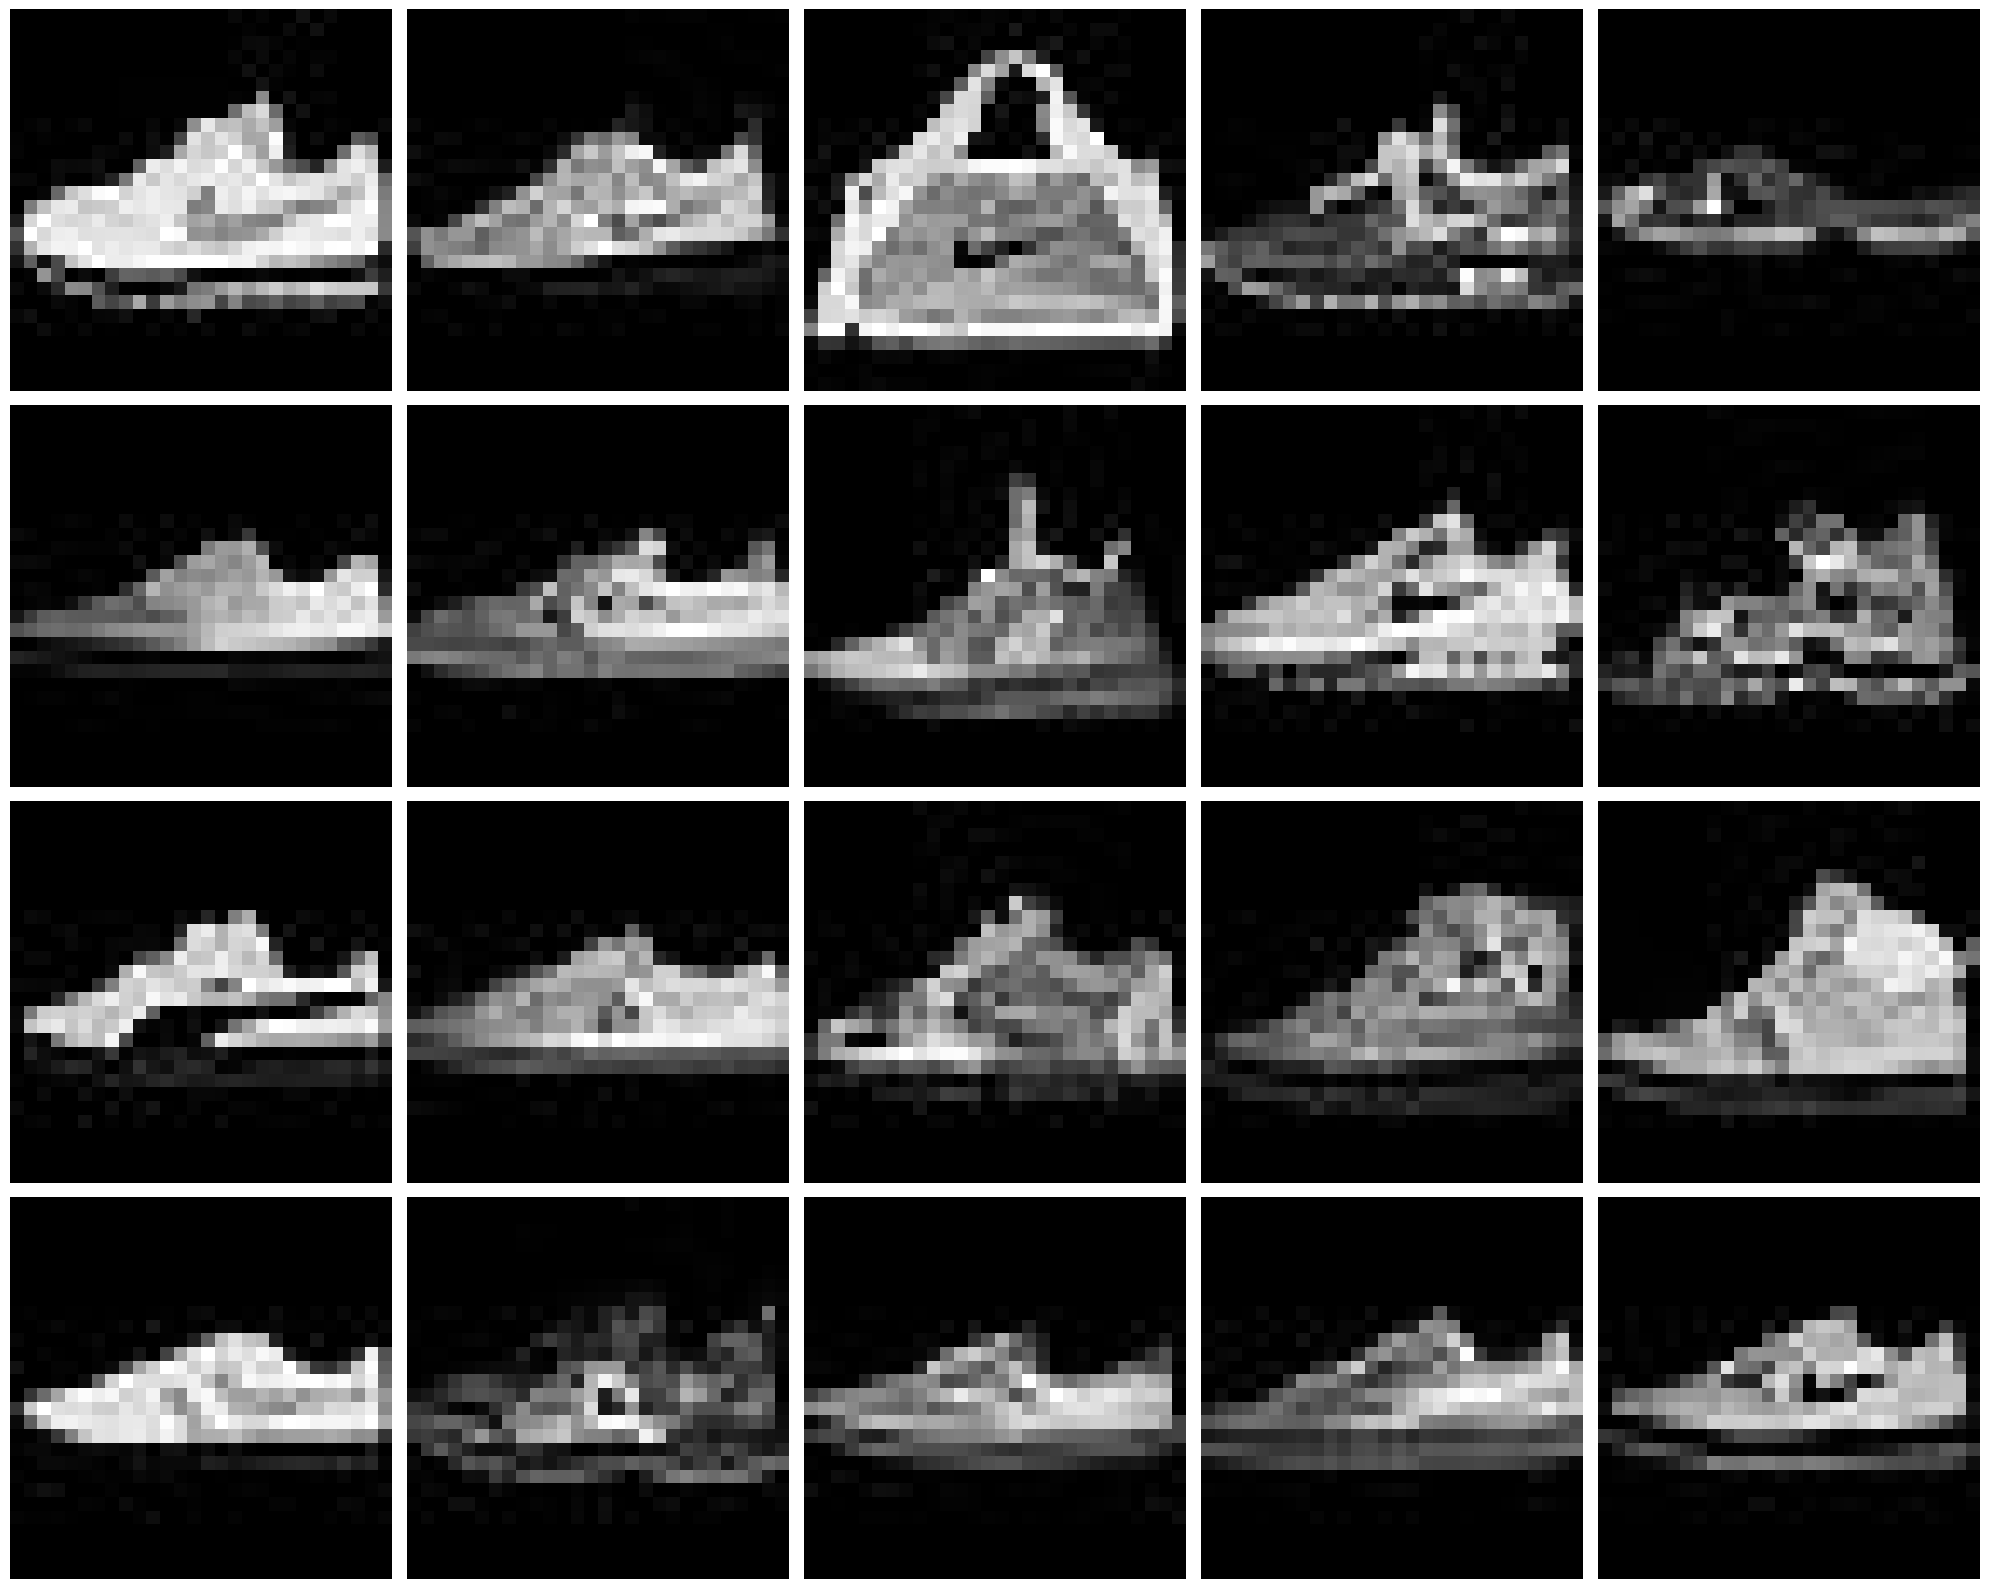

In [5]:
search_and_display_images(atlas_dataset, "nikes")